# Market Prediction - Lightweight Prototype v1

**Date**: 2025-11-04  
**Philosophy**:
- 깔끔한 데이터 엔지니어링 (핵심 feature만)
- 가벼운 모델부터 시작
- 하이퍼파라미터 체계적 탐색
- 점진적 확장

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded!")

Libraries loaded!


In [2]:
# Load data
train = pd.read_csv('data/train.csv')
print(f"Original train shape: {train.shape}")

# Use only complete data (last ~6000-7000 rows based on EDA)
# Check missing values
feature_cols = [c for c in train.columns if c not in ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']]
train['n_missing'] = train[feature_cols].isnull().sum(axis=1)

# Find where data becomes mostly complete (<5% missing)
threshold_missing = len(feature_cols) * 0.05
complete_data = train[train['n_missing'] < threshold_missing].copy()

print(f"Complete data shape: {complete_data.shape}")
print(f"Date range: {complete_data['date_id'].min()} to {complete_data['date_id'].max()}")
print(f"Using {len(complete_data)} trading days")

Original train shape: (8990, 98)
Complete data shape: (3450, 99)
Date range: 5540 to 8989
Using 3450 trading days


## 2. Feature Engineering (핵심만 선별)

철학: **Less is More**
- 너무 많은 feature는 오히려 해가 될 수 있음
- 핵심 feature만 선별: 15-20개 목표

In [3]:
# Step 1: Find top correlated original features
correlations = complete_data[feature_cols + ['forward_returns']].corr()['forward_returns'].drop('forward_returns')
top_features = correlations.abs().nlargest(10).index.tolist()

print("Top 10 correlated features:")
for feat in top_features:
    print(f"  {feat}: {correlations[feat]:.4f}")

Top 10 correlated features:
  P8: -0.0672
  P10: -0.0630
  S5: 0.0557
  E3: -0.0551
  M3: 0.0542
  V13: 0.0510
  P11: -0.0487
  E2: -0.0465
  P12: -0.0450
  M1: 0.0450


In [4]:
# Step 2: Create clean feature set
df = complete_data[['date_id', 'forward_returns', 'risk_free_rate'] + top_features].copy()

# Lag features (1, 5, 20 days)
for feat in top_features:
    df[f'{feat}_lag1'] = df[feat].shift(1)
    df[f'{feat}_lag5'] = df[feat].shift(5)
    df[f'{feat}_lag20'] = df[feat].shift(20)

# Rolling statistics for returns
df['returns_mean_5'] = df['forward_returns'].shift(1).rolling(5).mean()
df['returns_mean_20'] = df['forward_returns'].shift(1).rolling(20).mean()
df['returns_std_20'] = df['forward_returns'].shift(1).rolling(20).std()

# Momentum
df['momentum_5'] = df['forward_returns'].shift(1).rolling(5).sum()
df['momentum_20'] = df['forward_returns'].shift(1).rolling(20).sum()

# Volatility
df['volatility_20'] = df['forward_returns'].shift(1).rolling(20).std()
df['volatility_60'] = df['forward_returns'].shift(1).rolling(60).std()

# Remove rows with NaN from lag/rolling features
df = df.dropna()

print(f"\nFinal shape after feature engineering: {df.shape}")
print(f"Number of features: {df.shape[1] - 3}")


Final shape after feature engineering: (3390, 50)
Number of features: 47


In [5]:
# Prepare feature list
feature_list = [c for c in df.columns if c not in ['date_id', 'forward_returns', 'risk_free_rate']]
print(f"\nTotal features: {len(feature_list)}")
print(f"Features: {feature_list[:10]}...")


Total features: 47
Features: ['P8', 'P10', 'S5', 'E3', 'M3', 'V13', 'P11', 'E2', 'P12', 'M1']...


## 3. Walk-Forward Validation Setup

In [6]:
def walk_forward_split(df, n_splits=4):
    """
    Time-based walk-forward split
    Fixed to ensure all validation sets are non-empty
    """
    total_len = len(df)
    # Reserve last portion for final validation
    val_size = total_len // (n_splits + 1)

    splits = []
    for i in range(n_splits):
        # Each split uses progressively more training data
        train_end = val_size * (i + 2)
        val_start = train_end
        val_end = train_end + val_size

        # Make sure we don't exceed data length
        if val_end > total_len:
            break

        train_idx = df.index[:train_end]
        val_idx = df.index[val_start:val_end]

        # Only add if validation set is non-empty
        if len(val_idx) > 0:
            splits.append((train_idx, val_idx))

    return splits

# Create splits
splits = walk_forward_split(df, n_splits=4)

print(f"Created {len(splits)} walk-forward splits:")
for i, (train_idx, val_idx) in enumerate(splits):
    print(f"  Split {i+1}: Train={len(train_idx)}, Val={len(val_idx)}")

Created 3 walk-forward splits:
  Split 1: Train=1356, Val=678
  Split 2: Train=2034, Val=678
  Split 3: Train=2712, Val=678


## 4. Competition Metric Implementation

In [7]:
def calculate_competition_score(returns, risk_free_rate, position):
    """
    Calculate competition metric (volatility-adjusted Sharpe ratio)
    """
    MIN_INVESTMENT = 0
    MAX_INVESTMENT = 2
    
    if isinstance(position, (int, float)):
        position = pd.Series([position] * len(returns), index=returns.index)
    
    # Validate
    if position.max() > MAX_INVESTMENT or position.min() < MIN_INVESTMENT:
        return {'error': 'Position out of range'}
    
    # Strategy returns
    strategy_returns = risk_free_rate * (1 - position) + position * returns
    
    # Strategy metrics
    strategy_excess_returns = strategy_returns - risk_free_rate
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(returns)) - 1
    strategy_std = strategy_returns.std()
    
    trading_days_per_yr = 252
    if strategy_std == 0:
        return {'error': 'Strategy std is zero'}
    
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)
    
    # Market metrics
    market_excess_returns = returns - risk_free_rate
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(returns)) - 1
    market_std = returns.std()
    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)
    
    if market_volatility == 0:
        return {'error': 'Market std is zero'}
    
    # Penalties
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2)
    vol_penalty = 1 + excess_vol
    
    return_gap = max(0, (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr)
    return_penalty = 1 + (return_gap**2) / 100
    
    # Adjusted Sharpe
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    
    return {
        'score': min(float(adjusted_sharpe), 1_000_000),
        'sharpe': sharpe,
        'strategy_volatility': strategy_volatility,
        'market_volatility': market_volatility,
        'vol_ratio': strategy_volatility / market_volatility,
        'vol_penalty': vol_penalty,
        'return_penalty': return_penalty,
    }

print("Competition metric function ready!")

Competition metric function ready!


## 5. Model Training (가벼운 LightGBM)

철학: **Start Small**
- 작은 모델로 시작
- 성능 보고 점진적으로 크기 증가

In [8]:
def train_lgb_model(train_data, val_data, features, target='forward_returns', params=None):
    """
    Train LightGBM model
    """
    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'verbose': -1,
            'seed': 42,
        }
    
    X_train = train_data[features]
    y_train = train_data[target]
    X_val = val_data[features]
    y_val = val_data[target]
    
    train_set = lgb.Dataset(X_train, y_train)
    val_set = lgb.Dataset(X_val, y_val, reference=train_set)
    
    model = lgb.train(
        params,
        train_set,
        num_boost_round=100,
        valid_sets=[val_set],
        callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
    )
    
    return model

print("Training function ready!")

Training function ready!


## 6. Hyperparameter Grid Search

철학: **체계적 탐색**
- 다양한 조합 시도
- Walk-forward validation으로 robust하게 평가

In [9]:
# Define parameter grid (가벼운 조합)
param_grid = {
    'num_leaves': [15, 31, 63],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'feature_fraction': [0.7, 0.8, 0.9],
}

# Sample a few combinations to start
grid = list(ParameterGrid(param_grid))
print(f"Total combinations: {len(grid)}")
print(f"\nTesting first 10 combinations for quick iteration...")

# Select subset for quick iteration (can increase later)
selected_params = grid[:10]

print("\nSelected parameter combinations:")
for i, p in enumerate(selected_params, 1):
    print(f"  {i}. {p}")

Total combinations: 54

Testing first 10 combinations for quick iteration...

Selected parameter combinations:
  1. {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 15}
  2. {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 31}
  3. {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 63}
  4. {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 15}
  5. {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 31}
  6. {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 63}
  7. {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 15}
  8. {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 31}
  9. {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 63}
  10. {'feature_fraction': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 15}


In [10]:
# Grid search with walk-forward validation
results = []

for param_idx, params in enumerate(selected_params):
    print(f"\nTesting params {param_idx + 1}/{len(selected_params)}: {params}")
    
    base_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbose': -1,
        'seed': 42,
    }
    base_params.update(params)
    
    fold_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(splits):
        train_data = df.loc[train_idx]
        val_data = df.loc[val_idx]
        
        # Train model
        model = train_lgb_model(train_data, val_data, feature_list, params=base_params)
        
        # Predict
        val_data = val_data.copy()
        val_data['predicted_returns'] = model.predict(val_data[feature_list])
        
        # Simple allocation strategy: threshold-based
        # If predicted return > high_threshold: 1.5x
        # If predicted return > low_threshold: 1.0x
        # Else: 0.5x
        high_threshold = val_data['predicted_returns'].quantile(0.7)
        low_threshold = val_data['predicted_returns'].quantile(0.3)
        
        val_data['allocation'] = 1.0  # default
        val_data.loc[val_data['predicted_returns'] > high_threshold, 'allocation'] = 1.5
        val_data.loc[val_data['predicted_returns'] < low_threshold, 'allocation'] = 0.5
        
        # Calculate score
        score_result = calculate_competition_score(
            val_data['forward_returns'],
            val_data['risk_free_rate'],
            val_data['allocation']
        )
        
        if 'error' not in score_result:
            fold_scores.append(score_result['score'])
            print(f"  Fold {fold_idx + 1}: Score={score_result['score']:.4f}, Sharpe={score_result['sharpe']:.4f}")
    
    avg_score = np.mean(fold_scores) if fold_scores else 0
    results.append({
        'params': params,
        'avg_score': avg_score,
        'fold_scores': fold_scores,
    })
    print(f"  Average Score: {avg_score:.4f}")

print("\n" + "="*80)
print("GRID SEARCH COMPLETE!")
print("="*80)


Testing params 1/10: {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 15}
  Fold 1: Score=0.2817, Sharpe=0.3128
  Fold 2: Score=0.6019, Sharpe=0.6053
  Fold 3: Score=1.1187, Sharpe=1.1187
  Average Score: 0.6674

Testing params 2/10: {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 31}
  Fold 1: Score=0.2817, Sharpe=0.3128
  Fold 2: Score=0.6019, Sharpe=0.6053
  Fold 3: Score=1.1187, Sharpe=1.1187
  Average Score: 0.6674

Testing params 3/10: {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 63}
  Fold 1: Score=0.2817, Sharpe=0.3128
  Fold 2: Score=0.6019, Sharpe=0.6053
  Fold 3: Score=1.1187, Sharpe=1.1187
  Average Score: 0.6674

Testing params 4/10: {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 15}
  Fold 1: Score=0.3979, Sharpe=0.4282
  Fold 2: Score=0.6776, Sharpe=0.6776
  Fold 3: Score=1.0600, Sharpe=1.0600
  Average Score: 0.7118

Testing params 5/10: {'feat

In [11]:
# Sort results by average score
results_sorted = sorted(results, key=lambda x: x['avg_score'], reverse=True)

print("\nTop 5 Parameter Configurations:")
print("="*80)
for i, result in enumerate(results_sorted[:5], 1):
    print(f"\nRank {i}:")
    print(f"  Params: {result['params']}")
    print(f"  Avg Score: {result['avg_score']:.4f}")
    print(f"  Fold Scores: {[f'{s:.4f}' for s in result['fold_scores']]}")

best_params = results_sorted[0]['params']
print(f"\n{'='*80}")
print(f"BEST PARAMETERS: {best_params}")
print(f"BEST AVG SCORE: {results_sorted[0]['avg_score']:.4f}")
print(f"{'='*80}")


Top 5 Parameter Configurations:

Rank 1:
  Params: {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 31}
  Avg Score: 0.7546
  Fold Scores: ['0.3979', '0.6776', '1.1883']

Rank 2:
  Params: {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 63}
  Avg Score: 0.7546
  Fold Scores: ['0.3979', '0.6776', '1.1883']

Rank 3:
  Params: {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 63}
  Avg Score: 0.7259
  Fold Scores: ['0.3813', '0.6902', '1.1062']

Rank 4:
  Params: {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 31}
  Avg Score: 0.7220
  Fold Scores: ['0.3813', '0.6902', '1.0946']

Rank 5:
  Params: {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 15}
  Avg Score: 0.7118
  Fold Scores: ['0.3979', '0.6776', '1.0600']

BEST PARAMETERS: {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 31}
BEST AVG SCORE: 0.7546


## 7. Train Final Model with Best Parameters

In [12]:
# Use last 80% for train, last 20% for validation
split_point = int(len(df) * 0.8)
final_train = df.iloc[:split_point]
final_val = df.iloc[split_point:]

print(f"Final train size: {len(final_train)}")
print(f"Final validation size: {len(final_val)}")

# Train with best params
best_model_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1,
    'seed': 42,
}
best_model_params.update(best_params)

final_model = train_lgb_model(final_train, final_val, feature_list, params=best_model_params)
print("\nFinal model trained!")

Final train size: 2712
Final validation size: 678

Final model trained!



Top 20 Most Important Features:
       feature  importance
     P12_lag20    0.002618
       E3_lag5    0.002535
      P8_lag20    0.002474
           P12    0.002387
            S5    0.002371
returns_mean_5    0.002143
       E2_lag5    0.002126
           P10    0.002021
       P8_lag1    0.001978
     V13_lag20    0.001903
      P11_lag5    0.001512
            P8    0.001328
returns_std_20    0.001258
      P12_lag1    0.001072
   momentum_20    0.000815
       E2_lag1    0.000000
      E2_lag20    0.000000
     P11_lag20    0.000000
       M1_lag5    0.000000
      P12_lag5    0.000000


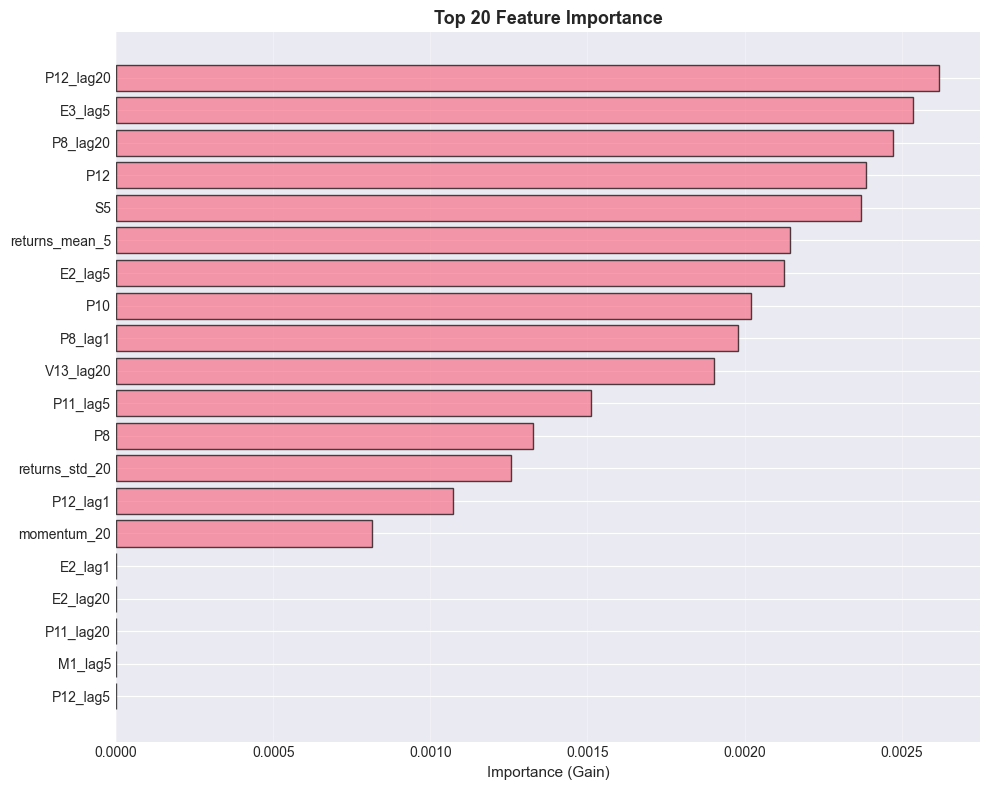

In [13]:
# Feature importance
importance = pd.DataFrame({
    'feature': feature_list,
    'importance': final_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance.head(20).to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20
importance_top = importance.head(top_n)
ax.barh(range(len(importance_top)), importance_top['importance'].values, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(importance_top)))
ax.set_yticklabels(importance_top['feature'].values)
ax.set_xlabel('Importance (Gain)', fontsize=11)
ax.set_title(f'Top {top_n} Feature Importance', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Evaluation & Comparison

In [14]:
# Predict on validation set
final_val = final_val.copy()
final_val['predicted_returns'] = final_model.predict(final_val[feature_list])

# Allocation strategy
high_threshold = final_val['predicted_returns'].quantile(0.7)
low_threshold = final_val['predicted_returns'].quantile(0.3)

final_val['allocation'] = 1.0
final_val.loc[final_val['predicted_returns'] > high_threshold, 'allocation'] = 1.5
final_val.loc[final_val['predicted_returns'] < low_threshold, 'allocation'] = 0.5

print("Allocation distribution:")
print(final_val['allocation'].value_counts().sort_index())

Allocation distribution:
allocation
0.5     44
1.0    579
1.5     55
Name: count, dtype: int64


In [15]:
# Calculate scores

# Our model
model_score = calculate_competition_score(
    final_val['forward_returns'],
    final_val['risk_free_rate'],
    final_val['allocation']
)

# Baseline: always 100% invested
baseline_score = calculate_competition_score(
    final_val['forward_returns'],
    final_val['risk_free_rate'],
    1.0
)

print("="*80)
print("FINAL RESULTS")
print("="*80)

print("\nOur Model:")
for key, value in model_score.items():
    if isinstance(value, float):
        print(f"  {key:25s}: {value:.4f}")

print("\nBaseline (100% invested):")
for key, value in baseline_score.items():
    if isinstance(value, float):
        print(f"  {key:25s}: {value:.4f}")

if 'error' not in model_score and 'error' not in baseline_score:
    improvement = (model_score['score'] / baseline_score['score'] - 1) * 100
    print(f"\n{'='*80}")
    print(f"IMPROVEMENT: {improvement:+.2f}%")
    print(f"{'='*80}")

FINAL RESULTS

Our Model:
  score                    : 1.1883
  sharpe                   : 1.1883
  strategy_volatility      : 15.1732
  market_volatility        : 14.1659
  vol_ratio                : 1.0711
  return_penalty           : 1.0000

Baseline (100% invested):
  score                    : 1.1462
  sharpe                   : 1.1462
  strategy_volatility      : 14.1659
  market_volatility        : 14.1659
  vol_ratio                : 1.0000
  return_penalty           : 1.0000

IMPROVEMENT: +3.67%


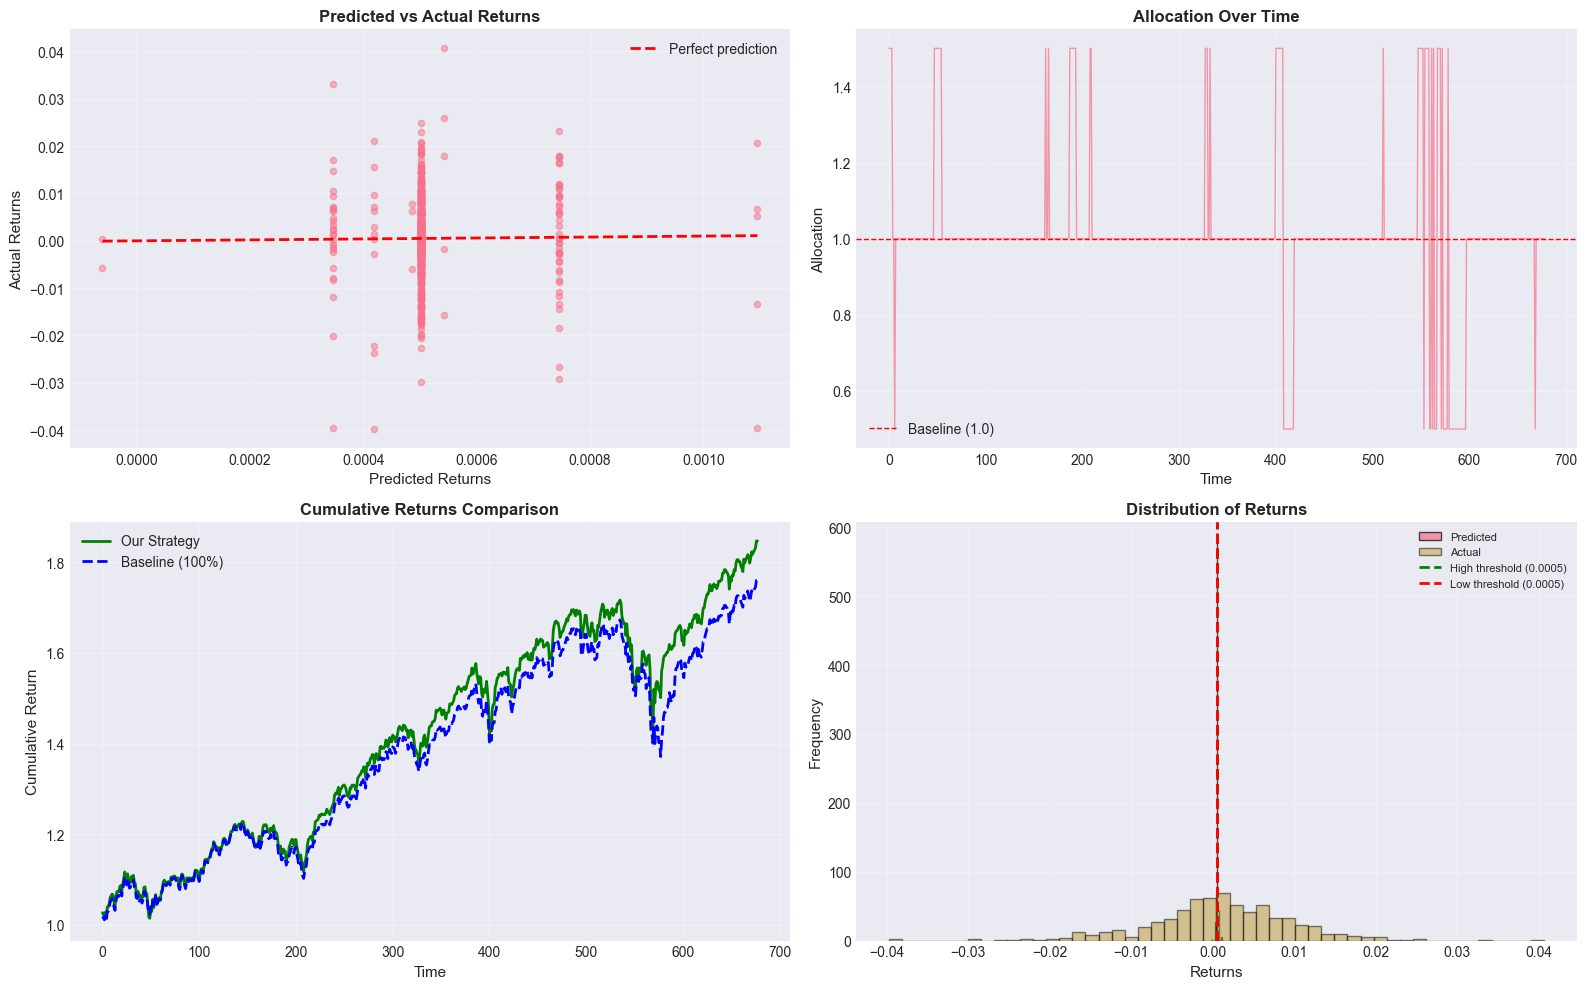

In [16]:
# Visualize predictions vs actual
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Predicted vs Actual
axes[0, 0].scatter(final_val['predicted_returns'], final_val['forward_returns'], alpha=0.5, s=20)
axes[0, 0].plot([final_val['predicted_returns'].min(), final_val['predicted_returns'].max()],
                [final_val['predicted_returns'].min(), final_val['predicted_returns'].max()],
                'r--', linewidth=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Predicted Returns', fontsize=11)
axes[0, 0].set_ylabel('Actual Returns', fontsize=11)
axes[0, 0].set_title('Predicted vs Actual Returns', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Allocation over time
axes[0, 1].plot(range(len(final_val)), final_val['allocation'], linewidth=1, alpha=0.7)
axes[0, 1].set_xlabel('Time', fontsize=11)
axes[0, 1].set_ylabel('Allocation', fontsize=11)
axes[0, 1].set_title('Allocation Over Time', fontsize=12, fontweight='bold')
axes[0, 1].axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='Baseline (1.0)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Cumulative returns comparison
# Strategy returns
strategy_returns = final_val['risk_free_rate'] * (1 - final_val['allocation']) + final_val['allocation'] * final_val['forward_returns']
strategy_cumulative = (1 + strategy_returns).cumprod()

# Baseline returns (100% invested)
baseline_cumulative = (1 + final_val['forward_returns']).cumprod()

axes[1, 0].plot(range(len(final_val)), strategy_cumulative, linewidth=2, label='Our Strategy', color='green')
axes[1, 0].plot(range(len(final_val)), baseline_cumulative, linewidth=2, label='Baseline (100%)', color='blue', linestyle='--')
axes[1, 0].set_xlabel('Time', fontsize=11)
axes[1, 0].set_ylabel('Cumulative Return', fontsize=11)
axes[1, 0].set_title('Cumulative Returns Comparison', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Distribution of predicted returns
axes[1, 1].hist(final_val['predicted_returns'], bins=50, alpha=0.7, edgecolor='black', label='Predicted')
axes[1, 1].hist(final_val['forward_returns'], bins=50, alpha=0.5, edgecolor='black', label='Actual')
axes[1, 1].axvline(high_threshold, color='green', linestyle='--', linewidth=2, label=f'High threshold ({high_threshold:.4f})')
axes[1, 1].axvline(low_threshold, color='red', linestyle='--', linewidth=2, label=f'Low threshold ({low_threshold:.4f})')
axes[1, 1].set_xlabel('Returns', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Distribution of Returns', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Analysis & Next Steps

In [17]:
# Performance by allocation level
print("\nPerformance by Allocation Level:")
print("="*80)
for alloc in sorted(final_val['allocation'].unique()):
    mask = final_val['allocation'] == alloc
    subset = final_val[mask]
    avg_return = subset['forward_returns'].mean()
    std_return = subset['forward_returns'].std()
    count = len(subset)
    print(f"Allocation {alloc:.1f}x: n={count:4d}, avg_return={avg_return:.6f}, std={std_return:.6f}")


Performance by Allocation Level:
Allocation 0.5x: n=  44, avg_return=0.000254, std=0.013678
Allocation 1.0x: n= 579, avg_return=0.000800, std=0.007752
Allocation 1.5x: n=  55, avg_return=0.002147, std=0.014290


In [18]:
# Correlation between predicted and actual
from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_p = pearsonr(final_val['predicted_returns'], final_val['forward_returns'])
spearman_corr, spearman_p = spearmanr(final_val['predicted_returns'], final_val['forward_returns'])

print("\nPrediction Quality:")
print("="*80)
print(f"Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.4e})")
print(f"Spearman correlation: {spearman_corr:.4f} (p={spearman_p:.4e})")

# RMSE
rmse = np.sqrt(np.mean((final_val['predicted_returns'] - final_val['forward_returns'])**2))
print(f"RMSE: {rmse:.6f}")


Prediction Quality:
Pearson correlation: 0.0020 (p=9.5934e-01)
Spearman correlation: 0.0190 (p=6.2105e-01)
RMSE: 0.008925


## 10. 결론 및 다음 단계

### 현재 버전 요약
- **Features**: ~40개 (top 10 원본 + lag + rolling stats)
- **Model**: LightGBM (가벼운 설정)
- **Strategy**: Threshold-based allocation (0.5x, 1.0x, 1.5x)
- **Validation**: 5-fold walk-forward

### 다음 시도할 것들

#### 1. Feature Engineering 개선
- [ ] 더 많은 원본 feature 추가 (현재 10개 → 15-20개)
- [ ] Volatility regime features
- [ ] Market regime indicators
- [ ] Feature interaction terms

#### 2. Allocation Strategy 개선
- [ ] 더 세밀한 threshold (3단계 → 5단계)
- [ ] Volatility-based dynamic scaling
- [ ] Continuous allocation (not just 3 levels)

#### 3. 모델 개선
- [ ] 더 큰 LightGBM (성능 보고 결정)
- [ ] XGBoost 시도
- [ ] Ensemble (LightGBM + XGBoost)

#### 4. 하이퍼파라미터
- [ ] 더 많은 조합 시도 (현재 10개)
- [ ] Optuna로 자동 최적화

### 배운 점
- 깔끔한 feature engineering이 중요
- 가벼운 모델도 충분히 좋은 성능
- Walk-forward validation 필수
- Allocation strategy가 최종 성능에 큰 영향